# 4.1. 多层感知机

## 4.1.1. 隐藏层

该模型通过单个仿射变换将我们的输入直接映射到输出，然后进行softmax操作。如果我们的标签通过仿射变换后确实与我们的输入数据相关，那么这种方法确实足够了。但是，仿射变换中的线性是一个很强的假设。

### 4.1.1.1. 线性模型可能会出错

线性意味着单调假设：任何特征的增大都会导致模型输出的增大（如果对应的权重为正），或者导致模型输出的减小（如果对应的权重为负）。

### 4.1.1.2. 在网络中加入隐藏层

我们可以通过在网络中加入一个或多个隐藏层来克服线性模型的限制，使其能处理更普遍的函数关系类型。要做到这一点，最简单的方法是将许多全连接层堆叠在一起。每一层都输出到上面的层，直到生成最后的输出。这种架构通常称为多层感知机（multilayer perceptron），通常缩写为MLP。 

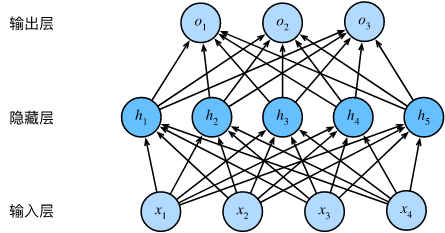

这个多层感知机有4个输入，3个输出，其隐藏层包含5个隐藏单元。输入层不涉及任何计算，因此使用此网络产生输出只需要实现隐藏层和输出层的计算。因此，这个多层感知机中的层数为2。注意，这两个层都是全连接的。每个输入都会影响隐藏层中的每个神经元，而隐藏层中的每个神经元又会影响输出层中的每个神经元。

具有全连接层的多层感知机的参数开销可能会高得令人望而却步。即使在不改变输入或输出大小的情况下，可能在参数节约和模型有效性之间进行权衡。

### 4.1.1.3. 从线性到非线性

### 4.1.1.4. 通用近似定理

事实上，通过使用更深（而不是更广）的网络，我们可以更容易地逼近许多函数。我们将在后面的章节中进行更细致的讨论。

## 4.1.2. 激活函数

激活函数（activation function）通过计算加权和并加上偏置来确定神经元是否应该被激活，它们将输入信号转换为输出的可微运算。

In [12]:
# !pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

In [22]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [14]:
# !pip uninstall matplotlib -y
# !pip install matplotlib==3.0.0

### 4.1.2.1. ReLU函数

最受欢迎的激活函数是修正线性单元（Rectified linear unit，ReLU），因为它实现简单，同时在各种预测任务中表现良好。

给定元素$x$，ReLU函数被定义为该元素与$0$的最大值：

**$$\operatorname{ReLU}(x) = \max(x, 0).$$**

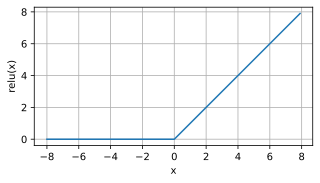

In [15]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))
# detach就是把网络中的一部分分量从反向传播的流程中拿出来，使之requires_grad=False

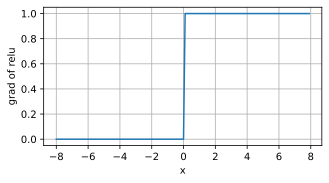

In [16]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

使用ReLU的原因是，它求导表现得特别好：要么让参数消失，要么让参数通过。这使得优化表现得更好，并且ReLU减轻了困扰以往神经网络的梯度消失问题。

### 4.1.2.2. sigmoid函数

sigmoid通常称为挤压函数（squashing function）：它将范围（-inf, inf）中的任意输入压缩到区间（0, 1）中的某个值。

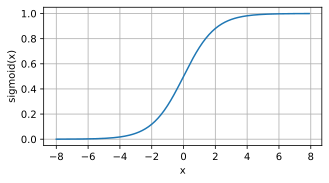

In [17]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

在最早的神经网络中，科学家们感兴趣的是对“激发”或“不激发”的生物神经元进行建模。阈值单元在其输入低于某个阈值时取值0，当输入超过阈值时取值1。

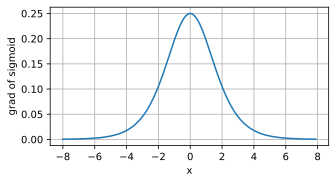

In [18]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

### 4.1.2.3. tanh函数

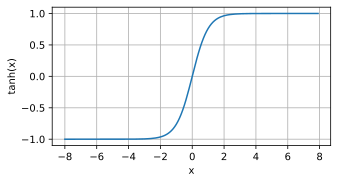

In [19]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

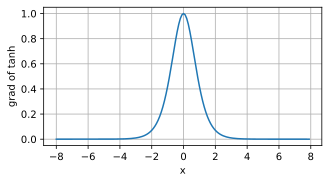

In [20]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

# 4.2. 多层感知机的从零开始实现

In [21]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 4.2.1. 初始化模型参数

回想一下，Fashion-MNIST中的每个图像由$28 \times 28 = 784$个灰度像素值组成。所有图像共分为10个类别。忽略像素之间的空间结构，我们可以将每个图像视为具有784个输入特征和10个类的简单分类数据集。首先，我们将**实现一个具有单隐藏层的多层感知机，它包含256个隐藏单元**。注意，我们可以将这两个变量都视为超参数。通常，我们选择2的若干次幂作为层的宽度。因为内存在硬件中的分配和寻址方式，这么做往往可以在计算上更高效。

注意，对于每一层我们都要记录一个权重矩阵和一个偏置向量。跟以前一样，我们要为损失关于这些参数的梯度分配内存。

In [26]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]
W1.shape

torch.Size([784, 256])

In [27]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## 4.2.3. 模型

因为我们忽略了空间结构，所以我们使用reshape将每个二维图像转换为一个长度为num_inputs的向量。只需几行代码就可以实现我们的模型。

In [28]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

## 4.2.4. 损失函数

In [29]:
loss = nn.CrossEntropyLoss(reduction='none')

## 4.2.5. 训练

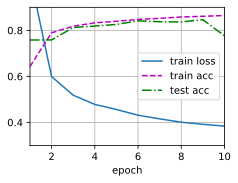

In [30]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

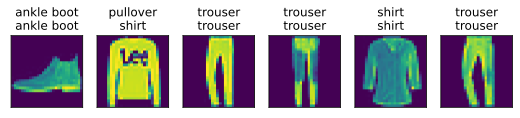

In [31]:
d2l.predict_ch3(net, test_iter)

# 4.3. 多层感知机的简洁实现

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [32]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

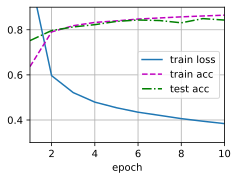

In [ ]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 4.4. 模型选择、欠拟合和过拟合

## 4.4.1. 训练误差和泛化误差

训练误差（training error）是指，模型在训练数据集上计算得到的误差。泛化误差（generalization error）是指，模型应用在同样从原始样本的分布中抽取的无限多数据样本时，模型误差的期望。

### 4.4.1.1. 统计学习理论

### 4.4.1.2. 模型复杂性

 通常对于神经网络，我们认为需要更多训练迭代的模型比较复杂，而需要“早停”（early stopping）的模型（即较少训练迭代周期）就不那么复杂。

 可调整参数的数量。当可调整参数的数量（有时称为自由度）很大时，模型往往更容易过拟合。

参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合。

训练样本的数量。即使你的模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型。

## 4.4.2. 模型选择

### 4.4.2.1. 验证集

原则上，在我们确定所有的超参数之前，我们不希望用到测试集。如果我们在模型选择过程中使用测试数据，可能会有过拟合测试数据的风险，那就麻烦大了。如果我们过拟合了训练数据，还可以在测试数据上的评估来判断过拟合。但是如果我们过拟合了测试数据，我们又该怎么知道呢？

解决此问题的常见做法是将我们的数据分成三份，除了训练和测试数据集之外，还增加一个验证数据集（validation dataset），也叫验证集（validation set）。但现实是验证数据和测试数据之间的边界模糊得令人担忧。除非另有明确说明，否则在这本书的实验中，我们实际上是在使用应该被正确地称为训练数据和验证数据的数据集，并没有真正的测试数据集。因此，书中每次实验报告的准确度都是验证集准确度，而不是测试集准确度。

### 4.4.2.2. K折交叉验证

## 4.4.3. 欠拟合还是过拟合？

如果模型不能降低训练误差，这可能意味着模型过于简单（即表达能力不足），无法捕获试图学习的模式。此外，由于我们的训练和验证误差之间的泛化误差很小，我们有理由相信可以用一个更复杂的模型降低训练误差。这种现象被称为欠拟合（underfitting）。

另一方面，当我们的训练误差明显低于验证误差时要小心，这表明严重的过拟合（overfitting）。注意，过拟合并不总是一件坏事。特别是在深度学习领域，众所周知，最好的预测模型在训练数据上的表现往往比在保留（验证）数据上好得多。最终，我们通常更关心验证误差，而不是训练误差和验证误差之间的差距。

### 4.4.3.1. 模型复杂性

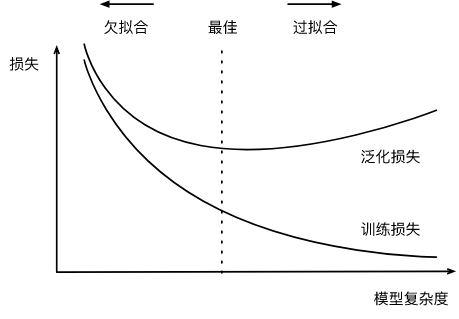

### 4.4.3.2. 数据集大小

训练数据集中的样本越少，我们就越有可能（且更严重地）过拟合。随着训练数据量的增加，泛化误差通常会减小。此外，一般来说，更多的数据不会有什么坏处。

## 4.4.4. 多项式回归

In [ ]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 4.4.4.1. 生成数据集

In [ ]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [ ]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.2945],
         [-1.3618]]),
 tensor([[ 1.0000e+00,  2.9447e-01,  4.3357e-02,  4.2558e-03,  3.1331e-04,
           1.8452e-05,  9.0560e-07,  3.8096e-08,  1.4023e-09,  4.5882e-11,
           1.3511e-12,  3.6169e-14,  8.8756e-16,  2.0105e-17,  4.2288e-19,
           8.3018e-21,  1.5279e-22,  2.6466e-24,  4.3298e-26,  6.7105e-28],
         [ 1.0000e+00, -1.3618e+00,  9.2721e-01, -4.2088e-01,  1.4329e-01,
          -3.9024e-02,  8.8570e-03, -1.7230e-03,  2.9330e-04, -4.4378e-05,
           6.0433e-06, -7.4814e-07,  8.4899e-08, -8.8933e-09,  8.6505e-10,
          -7.8533e-11,  6.6840e-12, -5.3541e-13,  4.0506e-14, -2.9032e-15]]),
 tensor([ 5.3271, -2.0585]))

### 4.4.4.2. 对模型进行训练和测试

In [ ]:
def evaluate_loss(net, data_iter, loss): 
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [ ]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 4.4.4.3. 三阶多项式函数拟合(正常)

weight: [[ 5.0043063  1.3154092 -3.3636453  5.3364553]]


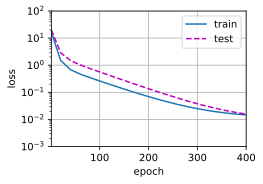

In [ ]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 4.4.4.4. 线性函数拟合(欠拟合)

weight: [[3.670178  3.0730023]]


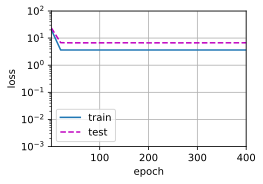

In [ ]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 4.4.4.5. 高阶多项式函数拟合(过拟合)

weight: [[ 5.01079941e+00  1.24108958e+00 -3.35845566e+00  5.32914543e+00
  -2.45633855e-01  1.19544029e+00  1.16200075e-01  3.68489057e-01
  -1.78160042e-01 -1.51104257e-01  4.98367986e-03 -1.33134604e-01
  -2.02493414e-01 -2.80370880e-02  6.31979406e-02 -3.92217413e-02
   8.36419389e-02 -1.38497919e-01  4.08231430e-02 -1.82717487e-01]]


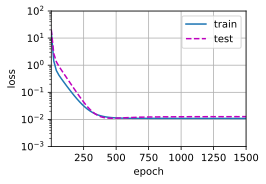

In [ ]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

# 4.5. 权重衰减

假设我们已经拥有尽可能多的高质量数据，我们便可以将重点放在正则化技术上。

## 4.5.1. 范数与权重衰减

在训练参数化机器学习模型时，权重衰减（weight decay）是最广泛使用的正则化的技术之一，它通常也被称为$L_2$正则化。

$L_2$正则化线性模型构成经典的岭回归（ridge regression）算法，$L_1$正则化线性回归是统计学中类似的基本模型，通常被称为套索回归（lasso regression）。使用$L_2$范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。在实践中，这可能使它们对单个变量中的观测误差更为稳定。相比之下，$L_1$惩罚会导致模型将权重集中在一小部分特征上，而将其他权重清除为零。这称为特征选择（feature selection），这可能是其他场景下需要的。

## 4.5.2. 高维线性回归

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 4.5.3. 从零开始实现

### 4.5.3.1. 初始化模型参数

In [ ]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 4.5.3.2. 定义$L_2$范数惩罚

In [ ]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### 4.5.3.3. 定义训练代码实现

In [ ]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### 4.5.3.4. 忽略正则化直接训练

w的L2范数是： 13.387301445007324


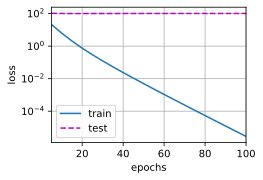

In [ ]:
train(lambd=0)

### 4.5.3.5. 使用权重衰减

w的L2范数是： 0.36248019337654114


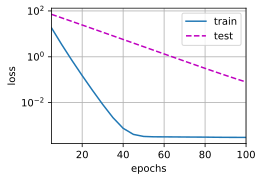

In [ ]:
train(lambd=3)

## 4.5.4. 简洁实现

In [ ]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.168386459350586


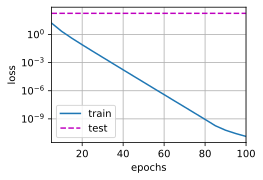

In [ ]:
train_concise(0)

w的L2范数： 0.5114636421203613


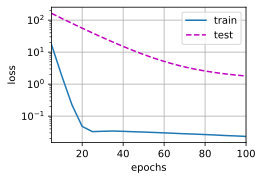

In [ ]:
train_concise(3)

# 4.6. 暂退法（Dropout）

## 4.6.1. 重新审视过拟合

泛化性和灵活性之间的这种基本权衡被描述为偏差-方差权衡（bias-variance tradeoff）。线性模型有很高的偏差：它们只能表示一小类函数。然而，这些模型的方差很低：它们在不同的随机数据样本上可以得出相似的结果。

深度神经网络位于偏差-方差谱的另一端。与线性模型不同，神经网络并不局限于单独查看每个特征，而是学习特征之间的交互。例如，神经网络可能推断“尼日利亚”和“西联汇款”一起出现在电子邮件中表示垃圾邮件，但单独出现则不表示垃圾邮件。

## 4.6.2. 扰动的稳健性

在训练过程中，他们建议在计算后续层之前向网络的每一层注入噪声。因为当训练一个有多层的深层网络时，注入噪声只会在输入-输出映射上增强平滑性。

这个想法被称为暂退法（dropout）。暂退法在前向传播过程中，计算每一内部层的同时注入噪声，这已经成为训练神经网络的常用技术。这种方法之所以被称为暂退法，因为我们从表面上看是在训练过程中丢弃（drop out）一些神经元。在整个训练过程的每一次迭代中，标准暂退法包括在计算下一层之前将当前层中的一些节点置零。

## 4.6.3. 实践中的暂退法

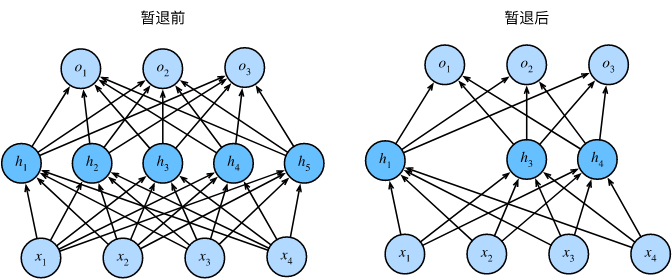

通常，我们在测试时不用暂退法。给定一个训练好的模型和一个新的样本，我们不会丢弃任何节点，因此不需要标准化。

# 4.6.4. 从零开始实现

然后我们保留那些对应样本大于$p$的节点，把剩下的丢弃。

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [ ]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  0.,  0.,  0.,  0., 14.],
        [ 0., 18., 20.,  0., 24., 26.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### 4.6.4.1. 定义模型参数

In [ ]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

### 4.6.4.2. 定义模型

In [ ]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

### 4.6.4.3. 训练和测试

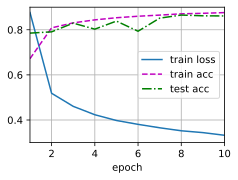

In [ ]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 4.6.5. 简洁实现

在训练时，Dropout层将根据指定的暂退概率随机丢弃上一层的输出（相当于下一层的输入）。在测试时，Dropout层仅传递数据。

In [ ]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

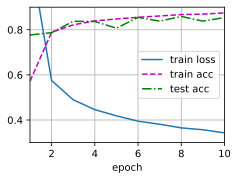

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 4.7. 前向传播、反向传播和计算图

## 4.7.1. 前向传播

前向传播（forward propagation或forward pass）指的是：按顺序（从输入层到输出层）计算和存储神经网络中每层的结果。

## 4.7.2. 前向传播计算图

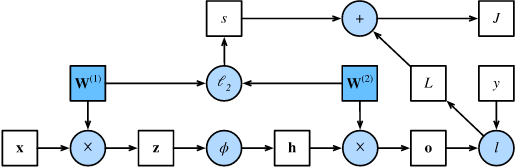

## 4.7.3. 反向传播

反向传播（backward propagation或backpropagation）指的是计算神经网络参数梯度的方法。简言之，该方法根据微积分中的链式规则，按相反的顺序从输出层到输入层遍历网络。

## 4.7.4. 训练神经网络

# 4.8. 数值稳定性和模型初始化

## 4.8.1. 梯度消失和梯度爆炸

要么是梯度爆炸（gradient exploding）问题：参数更新过大，破坏了模型的稳定收敛；要么是梯度消失（gradient vanishing）问题：参数更新过小，在每次更新时几乎不会移动，导致模型无法学习。

### 4.8.1.1. 梯度消失

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

正如你所看到的，当sigmoid函数的输入很大或是很小时，它的梯度都会消失。此外，当反向传播通过许多层时，除非我们在刚刚好的地方，这些地方sigmoid函数的输入接近于零，否则整个乘积的梯度可能会消失。

### 4.8.1.2. 梯度爆炸

In [ ]:
M = torch.normal(0, 1, size=(4,4))
print('一个矩阵 \n',M)
for i in range(100):
    M = torch.mm(M,torch.normal(0, 1, size=(4, 4)))

print('乘以100个矩阵后\n', M)

一个矩阵 
 tensor([[-1.0992, -0.4337,  0.7957, -0.7089],
        [-1.1888, -0.4128,  0.2527, -0.0419],
        [ 0.0249,  1.2310, -0.3883,  1.1923],
        [-0.7985, -2.0115,  0.3779,  2.0204]])
乘以100个矩阵后
 tensor([[-3.7811e+23,  2.0637e+23,  1.5763e+23, -2.6391e+22],
        [ 1.5718e+24, -8.5789e+23, -6.5529e+23,  1.0971e+23],
        [ 6.1545e+24, -3.3590e+24, -2.5657e+24,  4.2957e+23],
        [-1.4840e+24,  8.0994e+23,  6.1866e+23, -1.0358e+23]])


当这种情况是由于深度网络的初始化所导致时，我们没有机会让梯度下降优化器收敛。

### 4.8.1.3. 打破对称性

假设我们有一个简单的多层感知机，它有一个隐藏层和两个隐藏单元。在这种情况下，我们可以对第一层的权重$W^{(1)}$进行重排列，并且同样对输出层的权重进行重排列，可以获得相同的函数。第一个隐藏单元与第二个隐藏单元没有什么特别的区别。换句话说，我们在每一层的隐藏单元之间具有排列对称性。

## 4.8.2. 参数初始化

### 4.8.2.1. 默认初始化

如果我们不指定初始化方法，框架将使用默认的随机初始化方法，对于中等难度的问题，这种方法通常很有效。

### 4.8.2.2. Xavier初始化

# 4.9. 环境和分布偏移

有时，根据测试集的精度衡量，模型表现得非常出色。但是当数据分布突然改变时，模型在部署中会出现灾难性的失败。更隐蔽的是，有时模型的部署本身就是扰乱数据分布的催化剂。

总而言之，机器学习的许多应用中都存在类似的问题：通过将基于模型的决策引入环境，我们可能会破坏模型。

## 4.9.1. 分布偏移的类型

### 4.9.1.1. 协变量偏移

虽然输入的分布可能随时间而改变，但标签函数（即条件分布）没有改变。 统计学家称之为协变量偏移（covariate shift），因为这个问题是由于协变量（特征）分布的变化而产生的。

训练集由真实照片组成，而测试集只包含卡通图片。假设在一个与测试集的特征有着本质不同的数据集上进行训练，如果没有方法来适应新的领域，可能会有麻烦。

### 4.9.1.2. 标签偏移

例如，预测患者的疾病，我们可能根据症状来判断，即使疾病的相对流行率随着时间的推移而变化。标签偏移在这里是恰当的假设，因为疾病会引起症状。在另一些情况下，标签偏移和协变量偏移假设可以同时成立。 

### 4.9.1.3. 概念偏移

当标签的定义发生变化时，就会出现这种问题。

## 4.9.2. 分布偏移示例

### 4.9.2.1. 医学诊断

收集训练数据的分布和在实际中遇到的数据分布可能有很大的不同。

### 4.9.2.2. 自动驾驶汽车

对于一家想利用机器学习来开发自动驾驶汽车的公司，一个关键部件是“路沿检测器”。由于真实的注释数据获取成本很高，他们想出了一个“聪明”的想法：将游戏渲染引擎中的合成数据用作额外的训练数据。这对从渲染引擎中抽取的“测试数据”非常有效，但应用在一辆真正的汽车里真是一场灾难。

### 4.9.2.3. 非平稳分布

训练一个计算广告模型，但却没有经常更新（例如，一个2009年训练的模型不知道一个叫iPad的不知名新设备刚刚上市）。

建立一个垃圾邮件过滤器，它能很好地检测到所有垃圾邮件。但是，垃圾邮件发送者们变得聪明起来，制造出新的信息，看起来不像我们以前见过的任何垃圾邮件。

建立一个产品推荐系统，它在整个冬天都有效，但圣诞节过后很久还会继续推荐圣诞帽。

## 4.9.3. 分布偏移纠正

### 4.9.3.1. 经验风险与实际风险

经验风险（empirical risk）是为了近似真实风险（true risk），整个训练数据上的平均损失。

### 4.9.3.2. 协变量偏移纠正

### 4.9.3.3. 标签偏移纠正

### 4.9.3.4. 概念偏移纠正

## 4.9.4. 学习问题的分类法

### 4.9.4.1. 批量学习

例如，我们可以根据猫和狗的大量图片训练猫检测器。一旦我们训练了它，我们就把它作为智能猫门计算视觉系统的一部分，来控制只允许猫进入。然后这个系统会被安装在客户家中，基本再也不会更新。

### 4.9.4.2. 在线学习

例如，我们需要预测明天的股票价格，这样我们就可以根据这个预测进行交易。在一天结束时，我们会评估我们的预测是否盈利。换句话说，在在线学习（online learning）中，我们有以下的循环。在这个循环中，给定新的观测结果，我们会不断地改进我们的模型。

$\mathrm{model} ~ f_t \longrightarrow
\mathrm{data} ~ \mathbf{x}_t \longrightarrow
\mathrm{estimate} ~ f_t(\mathbf{x}_t) \longrightarrow
\mathrm{observation} ~ y_t \longrightarrow
\mathrm{loss} ~ l(y_t, f_t(\mathbf{x}_t)) \longrightarrow
\mathrm{model} ~ f_{t+1}$

### 4.9.4.3. 老虎机

虽然在大多数学习问题中，我们有一个连续参数化的函数$f$（例如，一个深度网络）。但在一个老虎机问题中，我们只有有限数量的手臂可以拉动。也就是说，我们可以采取的行动是有限的。

### 4.9.4.4. 控制

在很多情况下，环境会记住我们所做的事。不一定是以一种对抗的方式，但它会记住，而且它的反应将取决于之前发生的事情。例如，咖啡锅炉控制器将根据之前是否加热锅炉来观测到不同的温度。在这种情况下，PID（比例—积分—微分）控制器算法是一个流行的选择。同样，一个用户在新闻网站上的行为将取决于之前向她展示的内容（例如，大多数新闻她只阅读一次）。许多这样的算法形成了一个环境模型，在这个模型中，他们的行为使得他们的决策看起来不那么随机。

### 4.9.4.5. 强化学习

强化学习（reinforcement learning）强调如何基于环境而行动，以取得最大化的预期利益。国际象棋、围棋、西洋双陆棋或星际争霸都是强化学习的应用实例。再比如，为自动驾驶汽车制造一个控制器，或者以其他方式对自动驾驶汽车的驾驶方式做出反应（例如，试图避开某物体，试图造成事故，或者试图与其合作）。

### 4.9.4.6. 考虑到环境

在静止环境中可能一直有效的相同策略，在环境能够改变的情况下可能不会始终有效。

# 4.10. 实战Kaggle比赛：预测房价

## 4.10.1. 下载和缓存数据集

In [ ]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
def download(name, cache_dir=os.path.join('..', 'data')):  
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [ ]:
def download_extract(name, folder=None): 
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all(): 
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

## 4.10.2. Kaggle

## 4.10.3. 访问和读取数据集

In [ ]:
# 如果你没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = ( 
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [ ]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...


In [ ]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [ ]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [ ]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

### 4.10.4. 数据预处理

In [ ]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [ ]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [ ]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [ ]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## 4.10.5. 训练

In [ ]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [ ]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## 4.10.6. $K$折交叉验证

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 4.10.7. 模型选择

折1，训练log rmse0.169883, 验证log rmse0.156644
折2，训练log rmse0.161944, 验证log rmse0.189218
折3，训练log rmse0.163772, 验证log rmse0.168442
折4，训练log rmse0.167838, 验证log rmse0.154315
折5，训练log rmse0.163611, 验证log rmse0.182593
5-折验证: 平均训练log rmse: 0.165410, 平均验证log rmse: 0.170243


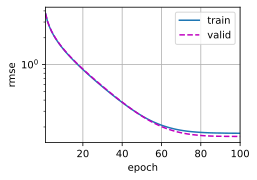

In [ ]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

## 4.10.8. 提交你的Kaggle预测

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162462


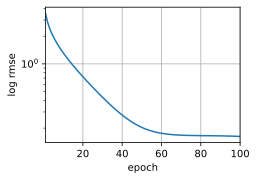

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)